In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
import numpy as np
from tqdm import tqdm_notebook
from torchvision.models import mobilenet_v3_small
from torchsummary import summary
import glob

import seaborn as sb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')


Using: cuda


In [2]:
model=mobilenet_v3_small(weights='DEFAULT')
model.classifier[3]=nn.Linear(in_features=1024,out_features=2,bias=True)

In [3]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src=None,paths=None):
        if src is not None:
            self.src=src
            self.images=os.listdir(src)
            
        else:
            self.src=None
            self.images=paths

        self.transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                       torchvision.transforms.CenterCrop((224,224))])
    
    def __len__(self):
        return len(self.images)


    def __getitem__(self,idx):
        if self.src is not None:
            img=cv2.imread(self.src+"/"+self.images[idx])
        else:
            img=cv2.imread(self.images[idx])
          
          
        pixelize=random.randint(0,1)

        
        t_lower = 50  # Lower Threshold 
        t_upper = 150  # Upper threshold 
        
        downsize=random.randint(0,1)

        if(downsize):
            image=img
            
            original_height, original_width = image.shape[:2]

            alpha = 2.0
            beta = 5.0
            
            random_beta = np.random.beta(alpha, beta)
            
            random_number = 1.6 + random_beta * (3 - 1.6)
            
            scale_factor = round(random_number, 1)


            new_width = int(original_width // scale_factor)
            new_height = int(original_height // scale_factor)  
            
            downscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
            
            upscaled_image = cv2.resize(downscaled_image, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

            upscaled_image=torch.from_numpy(cv2.Canny(upscaled_image,t_lower,t_upper)[np.newaxis,...])

            upscaled_image=torch.vstack((upscaled_image,upscaled_image,upscaled_image))
            return self.transforms(upscaled_image.type(torch.float32)), torch.tensor([0,1]).type(torch.float32)
                            
        else:
            
            img = torch.from_numpy(cv2.Canny(img,t_lower,t_upper)[np.newaxis,...])
            img = torch.vstack((img,img,img))
            
            return self.transforms(img.type(torch.float32)),torch.tensor([1,0]).type(torch.float32)
        

In [5]:
path='../../../coco_sample/train_sample/'
paths = glob.glob(path + "/*.jpg")

np.random.seed(123)
paths_subset = np.random.choice(paths, 14_000, replace=False) 
rand_idxs = np.random.permutation(14_000)
train_idxs = rand_idxs[:8000] 
val_idxs = rand_idxs[8000:10000] 
test_idxs = rand_idxs[10000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
test_paths = paths_subset[test_idxs]

In [6]:
train_ds=dataset(paths=train_paths)
val_ds=dataset(paths=val_paths)
test_ds=dataset(paths=test_paths)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([1., 0.])


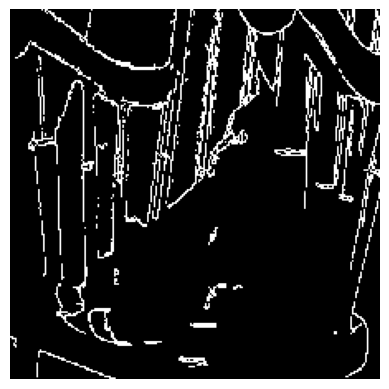

In [7]:
plt.axis(False)
t=train_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [8]:
torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
train_loader=torch.utils.data.DataLoader(train_ds,16,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_ds,16,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [10]:
x,y=next(iter(train_loader))
print(x.shape)
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

torch.Size([16, 3, 224, 224])


tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0])

In [11]:
y

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])

In [12]:
loss_fn=nn.CrossEntropyLoss()

In [13]:
with torch.inference_mode():
    logits=model(x)
    torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),torch.argmax(y,dim=1)).sum().item()/len(logits)
    print(loss_fn(torch.squeeze(logits,dim=1),y))

tensor(0.7234)


In [14]:
model=model.to(device)

In [15]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    max_acc=0
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
      
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(torch.squeeze(logits,dim=1),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    accuracy_train=accuracy_fn(logits.type(torch.float32),torch.argmax(y,dim=1))
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    
        #Evaluation
        print("Testing:")
        model.eval()

        
    
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    accuracy_val=accuracy_fn(logits,torch.argmax(y,dim=1))
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
        
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
     
        if(net_val_accuracy>max_acc):
            if(max_acc!=0):
                os.remove(f'method2({max_acc:.3f}).pt')
            max_acc=net_val_accuracy
            print(f'Saving model')
            torch.save(model.state_dict(),f'method2({net_val_accuracy:.3f}).pt')
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}")


def test_model(model):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    test_preds=torch.tensor([])
    test_actual=torch.tensor([])

    
    predictions=[]
    targets=[]
    
    temp_test_accuracy=[]
    temp_test_loss=[]

    net_test_accuracy=0
    net_test_loss=0

    #Evaluation
    print("Testing:")
    model.eval()

    

    with tqdm_notebook(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                
                #Track of metrics
                preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                accuracy_test=accuracy_fn(logits,torch.argmax(y,dim=1))
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())
                predictions.extend(torch.argmax(torch.softmax(logits,dim=1),dim=1).tolist())
                targets.extend(torch.argmax(y, dim=1).tolist())

                #Progress Bar Update
                pbar2.update(1)
                
                
        pbar2.close()

    

    conf_matrix = confusion_matrix(targets, predictions)

    # Calculate precision, recall, and F1 score
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    
    print("Confusion Matrix:")
    print("\nPrecision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)

    print(f"Test Accuracy: {net_test_accuracy}\nTest Loss: {net_test_loss}")

    plt.figure(figsize=(10, 7))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pixelated'], yticklabels=['Normal', 'Pixelated'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
train_model(model,20)

  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 1:

Train Accuracy: 0.93325

Train Loss: 0.16561153363855555

Val Accuracy: 0.7155

Val Loss: 1.6242257801890374

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 2:

Train Accuracy: 0.962125

Train Loss: 0.10872595985757652

Val Accuracy: 0.97

Val Loss: 0.09141269408911466

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.969875

Train Loss: 0.08709958950034342

Val Accuracy: 0.882

Val Loss: 0.3643292704820633

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 4:

Train Accuracy: 0.976875

Train Loss: 0.06447086778143421

Val Accuracy: 0.9705

Val Loss: 0.07805769095331197

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.982125

Train Loss: 0.05638880772816628

Val Accuracy: 0.786

Val Loss: 1.0094425829648972

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 6:

Train Accuracy: 0.97825

Train Loss: 0.05986438336929859

Val Accuracy: 0.98

Val Loss: 0.048703860315494236

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.97525

Train Loss: 0.0741089574101934

Val Accuracy: 0.9555

Val Loss: 0.16150729021430016

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 8:

Train Accuracy: 0.98375

Train Loss: 0.04468104293440842

Val Accuracy: 0.982

Val Loss: 0.04645927072796621

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 9:

Train Accuracy: 0.9855

Train Loss: 0.03937165258580444

Val Accuracy: 0.9895

Val Loss: 0.02906896200752817

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.98525

Train Loss: 0.04612611890735195

Val Accuracy: 0.9355

Val Loss: 0.1692353625614196

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.988125

Train Loss: 0.036498543807595527

Val Accuracy: 0.9735

Val Loss: 0.08893905889484541

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.985375

Train Loss: 0.0420144176611293

Val Accuracy: 0.864

Val Loss: 0.32673420122265817

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.98875

Train Loss: 0.034522409535849195

Val Accuracy: 0.884

Val Loss: 0.7072564052162342

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.98675

Train Loss: 0.03977420660219923

Val Accuracy: 0.982

Val Loss: 0.04835025449663226

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.989

Train Loss: 0.03216493549562159

Val Accuracy: 0.9705

Val Loss: 0.11930573271256889

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.989

Train Loss: 0.029921482979333405

Val Accuracy: 0.9865

Val Loss: 0.044817178282069964

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 0.985

Train Loss: 0.0552915163835919

Val Accuracy: 0.9495

Val Loss: 0.1395017016697675

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 0.993

Train Loss: 0.02129764342740427

Val Accuracy: 0.842

Val Loss: 0.7152598072171676

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 19:

Train Accuracy: 0.98825

Train Loss: 0.044542806871836

Val Accuracy: 0.965

Val Loss: 0.10924616137880366

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 20:

Train Accuracy: 0.9895

Train Loss: 0.03574853049332796

Val Accuracy: 0.9835

Val Loss: 0.04979571754770586


Testing:


  0%|          | 0/250 [00:00<?, ?it/s]

Confusion Matrix:

Precision: 0.9920279023418037
Recall: 0.9832098765432099
F1 Score: 0.9875992063492064
Test Accuracy: 0.9875
Test Loss: 0.03567060264130123


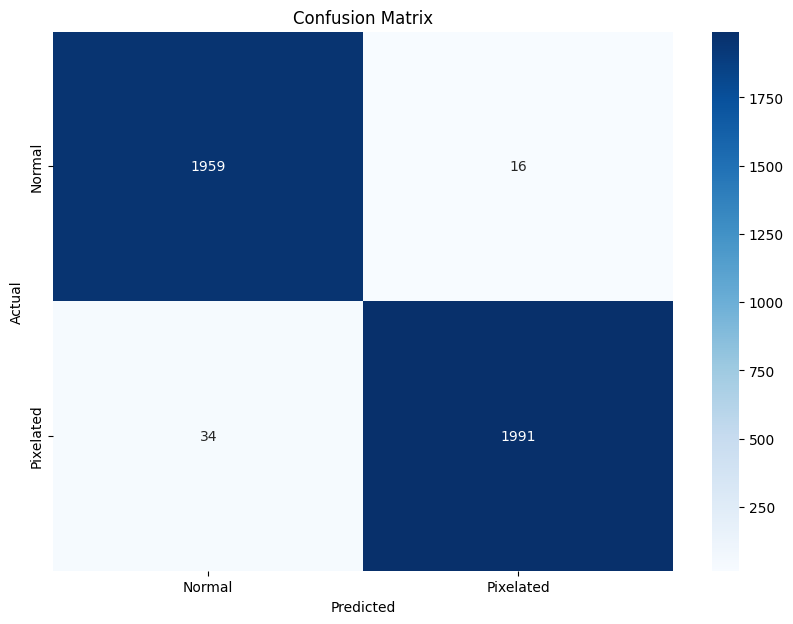

In [17]:
model.load_state_dict(torch.load('./method2(0.990).pt'))
test_model(model)

In [18]:
x,y=next(iter(val_loader))
x=x.to(device)
y=y.to(device)

In [19]:
with torch.inference_mode():
    output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
    print(output)

tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')


In [20]:
torch.argmax(y,dim=1)

tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')

In [21]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 5.844MB
